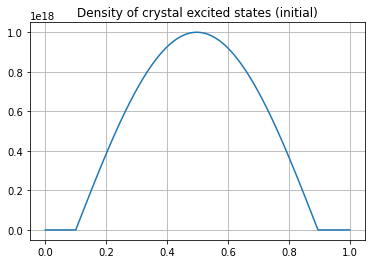

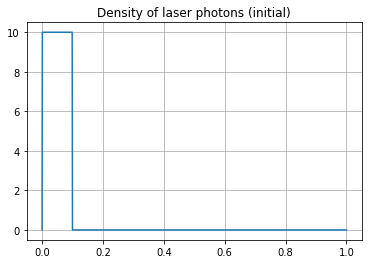


 # of time steps =  1001
 # cells along x =  1000




RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  74d7efe1e84d65e9433fd96c50f1d278fa3e3f3f
*** -------------------------------------------------------------------------


In [18]:
'''
File:  fn_simp_05.py

This test shows a static distribution of excited states in a crystal,
with an laser envelope of photons that sweep across the crystal.

The only dynamical equation is that of the excited states in the crystal.

Experimenting with different solver here...
'''
from dolfin import *
import matplotlib.pyplot as plt

# Specify the BCs
def on_left(x, on_boundary):
    return (on_boundary and near(x[0], 0.))

def on_right(x, on_boundary):
    return (on_boundary and near (x[0], 1.))

V_x = 0.8
n_ds = 1000
ds = 1./n_ds
lp_density = 10.
lp_width = 0.1
c_density = 1.e18
c_width = 1. - 2.*lp_width - 4.*ds
c_sigma = 1.e-19

# create a 1D mesh on the interval [0,1]
mesh = UnitIntervalMesh(n_ds)
V = FunctionSpace(mesh, "DG", 1)
v = TestFunction(V)

u = Function(V)
uprev = Function(V)
    
# instantiate the corresponding FEniCS objects for Dirichlet BCs
bc_left = DirichletBC(V, Constant(0), on_left)
bc_right = DirichletBC(V, Constant(0), on_right)
bc = [bc_left, bc_right]

# initial conditions for number density of excited states
u0 = Expression(('x[0]>=lp_width && x[0]<=(lp_width+c_width) ? \
                c_density*sin(pi*(x[0]-lp_width)/c_width) : 0.'), \
                degree=1, lp_width=0.2, c_width=0.6, c_density=1., ds=0.01)
u0.c_width = c_width
u0.lp_width = lp_width
u0.c_density = c_density
u0.ds = ds
    
# project the above expression onto the solution vector
uprev = interpolate(u0, V)

# define the externally imposed laser pulse
ulaser = Expression(('(x[0]-V_x*t)>ds && (x[0]-V_x*t)<lp_width ? lp_density : 0.'), \
                degree=0, lp_width=0.1, ds=0.01, V_x=0.6, lp_density=1., t=0.)
ulaser.lp_density = lp_density
ulaser.lp_width = lp_width
ulaser.ds = ds
ulaser.V_x = V_x

# inital plot of excited states and laser pulse envelope
uplot = project(uprev, V)
plot(uplot, title=('Density of crystal excited states (initial)'))
plt.grid(True)
plt.show()
plt.close()

uplot = project(ulaser, V)
plot(uplot, title=('Density of laser photons (initial)'))
plt.grid(True)
plt.show()
plt.close()

time = 1.
dt = 0.8 * ds / V_x
n_steps = int(1 + time / dt)

print('')
print(' # of time steps = ', n_steps)
print(' # cells along x = ', n_ds)
print('')
print('')

DT = Constant(dt)
VX = Constant(V_x)
SIGMA = Constant(c_sigma)

# try to get some numerical diagnostics
set_log_level(LogLevel.INFO)

u = Function(V)
t=0.5*dt
for i_loop in range(0, n_steps):
    ulaser.t = t
    t += dt

    F = ( (u - uprev) * v / DT + SIGMA * u * ulaser * v ) * dx
    
    Jacobian = derivative(F, u)
    problem = NonlinearVariationalProblem(F, u, bc, Jacobian)
    solver  = NonlinearVariationalSolver(problem)
    
    prm = solver.parameters
    prm['newton_solver']['absolute_tolerance'] = 1E-5
    prm['newton_solver']['relative_tolerance'] = 1E-3
    prm['newton_solver']['maximum_iterations'] = 25
    prm['newton_solver']['relaxation_parameter'] = 1.0
    prm['newton_solver']['linear_solver'] = 'gmres'
    prm['newton_solver']['preconditioner'] = 'default'
    prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-5
    prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-3
    prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
    prm['newton_solver']['krylov_solver']['monitor_convergence'] = True
    prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
    solver.solve()
    uprev.assign(u)
    
#    print('i_loop = ', i_loop)
#    if i_loop > 200:
#        break

# final plot of excited states and laser pulse envelope
uplot = project(u, V)
plot(uplot, title=('Density of crystal excited states (final)'))
plt.grid(True)
plt.show()
plt.close()

uplot = project(ulaser, V)
plot(uplot, title=('Density of laser photons (initial)'))
plt.grid(True)
plt.show()
plt.close()

In [19]:
list_krylov_solver_preconditioners()